In [1]:
import sys
from pathlib import Path

script_dir = Path().resolve()
root_dir = (script_dir.parent)
sys.path.append(str(root_dir))

import pandas as pd
import numpy as np

from endata.datasets.timeseries_dataset import TimeSeriesDataset
from endata.trainer import Trainer

/home/fuest/EnData/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Training a model from scratch ##

To train your own model from scratch, the ` Trainer ` class provides a simple implementation. Simply define your a custom dataset and a ` Trainer ` object, and call the ` Trainer ` 's ` fit() ` method.

## Writing a custom dataset ##

When creating a custom time series dataset class for use with EnData, the class must inherit from the provided `TimeSeriesDataset` base class. The `TimeSeriesDataset` class provides a robust and modular framework for handling wide-format time series data. Custom implementations only need to assign a name to `self.name` and implement the `_preprocess_data` method, which is an abstract method in the base class. This method should ensure that the data is available in a clean wide-format data frame, that has the structure outlined below.

### Responsibilities of `_preprocess_data`

- Preprocess raw input data into a DataFrame that satisfies the expected structure.
- Ensure time series columns contain arrays of the correct sequence length (`seq_len`).
- Add any additional columns, such as entity identifiers or context variables.

### Benefits of the Base Class

- **Normalization and Scaling:** Automatically handles standardization and min-max scaling.
- **context Variables:** Provides support for encoding and managing context variables.
- **Time Series Merging and Splitting:** Facilitates operations to merge multiple time series columns into a single multidimensional array and split them back when needed.
- **Data Transformation:** Includes functions for inverse transformations to revert normalized data to its original scale.

---

### Expected Input DataFrame Structure

The input to the `TimeSeriesDataset` class must adhere to the following structure:

| **Column Name**       | **Description**                                                                                     |
|------------------------|-----------------------------------------------------------------------------------------------------|
| `timeseries_col1`      | A column containing arrays of length `seq_len` (after preprocessing) representing the first dimension of the time series. |
| `timeseries_col2`      | A column containing arrays of length `seq_len` (after preprocessing) representing the second dimension of the time series.|
| `entity_column`        | A column containing unique identifiers for each entity (e.g., user, household, or device ID).       |
| `context_var1`    | An (optional) static or numeric context variable (e.g., categorical or continuous feature).                |
| `context_var2`    | Further (optional) static or numeric context variables.                                                    |

- The `time_series_column_names` parameter specifies which columns are part of the time series.
- The `entity_column_name` parameter identifies the column containing unique entity IDs.
- The `context_var_column_names` parameter defines additional context variables.

---

In [2]:
class CustomTimeSeriesDataset(TimeSeriesDataset):
    """
    A custom TimeSeriesDataset implementation for handling toy data.

    Input data structure:
    - time_series_col1, time_series_col2: Time series data with arrays of length seq_len.
    - entity_id: Unique identifier for each entity.
    - static_context: Categorical or numeric context variable.
    """
    def __init__(
        self,
        data: pd.DataFrame,
        seq_len: int = 16,
        normalize: bool = True,
        scale: bool = True,
    ):
        time_series_column_names = ["time_series_col1", "time_series_col2"]
        context_var_column_names = ["context_var"]

        super().__init__(
            data=data,
            time_series_column_names=time_series_column_names,
            context_var_column_names=context_var_column_names,
            seq_len=seq_len,
            normalize=normalize,
            scale=scale,
        )

    def _preprocess_data(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Preprocesses the raw input data to ensure it conforms to the expected format.

        - Ensures time series columns contain arrays of length seq_len.
        - Ensures all required columns are present.

        Args:
            data (pd.DataFrame): The raw input data.

        Returns:
            pd.DataFrame: The preprocessed data.
        """
        required_columns = ["time_series_col1", "time_series_col2", "context_var"]
        for col in required_columns:
            if col not in data.columns:
                raise ValueError(f"Missing required column: {col}")

        for col in ["time_series_col1", "time_series_col2"]:
            data[col] = data[col].apply(
                lambda x: np.array(x).reshape(-1, 1) if isinstance(x, list) else x
            )
            data[col] = data[col].apply(
                lambda x: np.array(x) if isinstance(x, np.ndarray) else ValueError(f"Invalid data in {col}")
            )
        for col in ["time_series_col1", "time_series_col2"]:
            data[col] = data[col].apply(
                lambda x: x[:self.seq_len] if len(x) >= self.seq_len else ValueError(f"Sequence too short in {col}")
            )
        return data

Now that we have defined our dataset class, let's create some artificial timeseries columns and context variables which will comprise our dataset:

In [3]:
data = pd.DataFrame({
        "time_series_col1": [np.random.rand(16) for _ in range(100)],
        "time_series_col2": [np.random.rand(16) for _ in range(100)],
        "context_var": np.random.choice(["a", "b", "c"], size=100).tolist(),
    })

custom_dataset = CustomTimeSeriesDataset(data)
custom_dataset.data

[EnData] Loaded cached normaliser from /home/fuest/.cache/endata/checkpoints/custom/custom_dim_2_scale_True_normalizer.pt


,index,context_var,timeseries,is_frequency_rare,cluster,is_pattern_rare,is_rare
0,0,1,"[[0.21562546, 0.35961202], [0.8201423, 0.40768...",False,2,True,False
1,1,2,"[[0.1531171, 0.59697306], [1.0225127, 0.632528...",False,1,True,False
2,2,1,"[[1.1654676, 1.1404527], [0.9256324, 0.8565166...",False,9,True,False
3,3,2,"[[0.28231886, 0.30929014], [0.96346205, 0.7174...",False,2,True,False
4,4,1,"[[0.43307924, 1.085096], [0.45774284, 0.356203...",False,9,True,False
...,...,...,...,...,...,...,...
95,95,1,"[[0.443474, 0.9488078], [0.61336756, 0.9086771...",False,0,True,False
96,96,2,"[[0.5912961, 0.22665796], [0.22946638, 1.02330...",False,4,False,False
97,97,1,"[[0.7271406, 0.7751696], [0.8428504, 0.2663241...",False,5,True,False
98,98,1,"[[1.0106304, 0.5821649], [0.25899073, 1.040661...",False,8,True,False


We will now create a `Trainer` object by passing the name of the desired model and the dataset object. To start training, simply call `Trainer.fit()`.

In [4]:
trainer = Trainer(model="acgan", dataset=custom_dataset, overrides=["trainer.max_epochs=5"])
trainer.fit()

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | context_module | ContextModule     | 4.3 K  | train
1 | generator      | Generator         | 309 K  | train
2 | discriminator  | Discriminator     | 167 K  | train
3 | adv_loss       | BCEWithLogitsLoss | 0      | train
4 | aux_loss       | CrossEntropyLoss  | 0      | train
-------------------------------------------------------------
477 K     Trainable params
0         Non-trainable para

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, loss_G=1.900, loss_D=3.790]        

/home/fuest/EnData/venv/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['loss_G', 'loss_D', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s, v_num=0, loss_G=1.820, loss_D=3.520]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s, v_num=0, loss_G=1.820, loss_D=3.520]


Once training is complete, we can create a data generator object that has access to the trained model and dataset information. To generate data, there is no need to load in a trained model. Simply define the context variables, and call the `DataGenerator` 's `generate()` method.

In [5]:
data_generator = trainer.get_data_generator()

In [6]:
data_generator.set_context(context_var=2)
generated_df = data_generator.generate(n=100)
generated_df

,context_var,time_series_col1,time_series_col2
0,2,"[0.40900716, 0.446997, 0.3964866, 0.39435133, ...","[0.33603737, 0.2871971, 0.40165797, 0.3460291,..."
1,2,"[0.37599152, 0.38579163, 0.37847304, 0.4027235...","[0.2926368, 0.26988274, 0.36068842, 0.31112808..."
2,2,"[0.40771675, 0.41369122, 0.4145048, 0.3072111,...","[0.3292057, 0.2945654, 0.3826436, 0.35200202, ..."
3,2,"[0.38580972, 0.4702887, 0.35829234, 0.38054127...","[0.30119407, 0.21517809, 0.33657274, 0.3715543..."
4,2,"[0.38426703, 0.38841715, 0.4062786, 0.3690819,...","[0.3371351, 0.29021418, 0.39321095, 0.2973331,..."
...,...,...,...
95,2,"[0.39562523, 0.3480563, 0.36919948, 0.34442207...","[0.28245917, 0.29289994, 0.35875186, 0.3691977..."
96,2,"[0.3910022, 0.39185268, 0.39432943, 0.4045694,...","[0.31599668, 0.35182256, 0.41791928, 0.1461173..."
97,2,"[0.40920794, 0.3971255, 0.39004087, 0.25622213...","[0.30258462, 0.3424039, 0.3171202, 0.2789588, ..."
98,2,"[0.41538322, 0.36147436, 0.4469483, 0.35417572...","[0.32179213, 0.33462822, 0.3733905, 0.36375162..."


# Model Evaluation

The `Evaluator` class provides functionality to assess the quality of generated data compared to the original training data. It computes various metrics including:

- Distribution similarity between real and generated data
- Utility metrics
- Context-FID

To evaluate the trained model, we can use the `evaluate()` method of the `Trainer`. This method accepts:

- A dataset to evaluate against (typically the training dataset)
- Optional evaluation configuration parameters

The evaluation results provide insights into how well the model captures the underlying data patterns and maintains the relationship with context variables.

Let's run an evaluation on our trained model:

Training Predictive Score Model: 100%|██████████| 5000/5000 [00:34<00:00, 146.92it/s]
/home/fuest/EnData/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/fuest/EnData/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


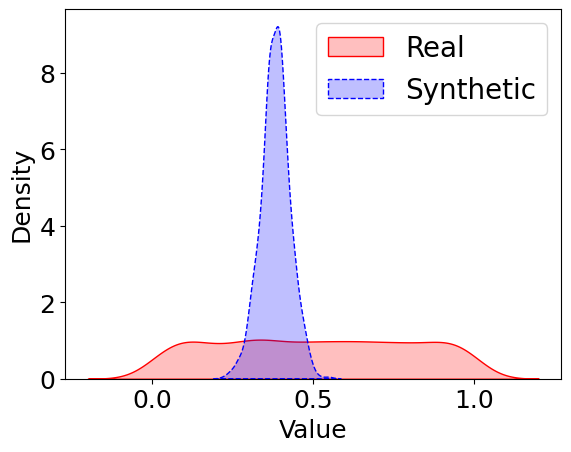

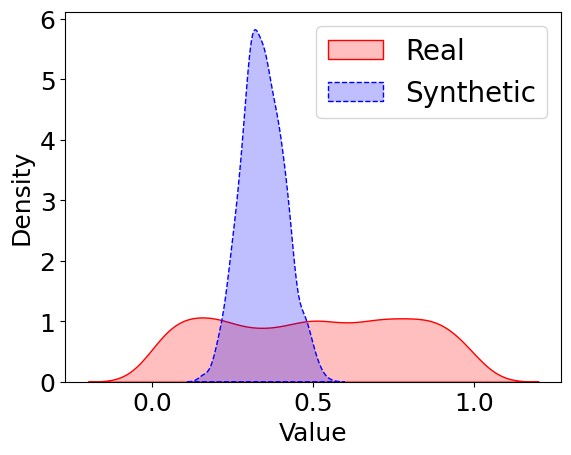

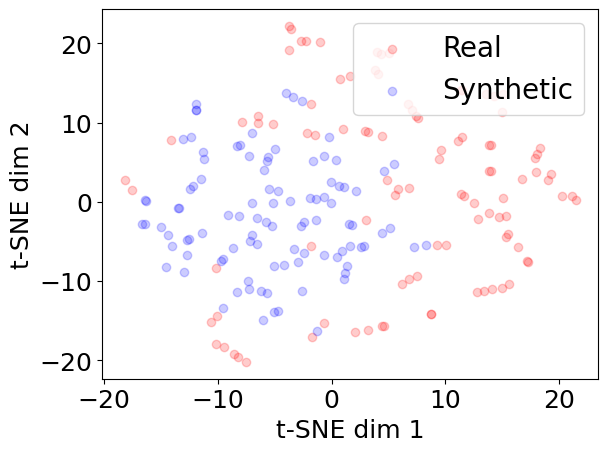

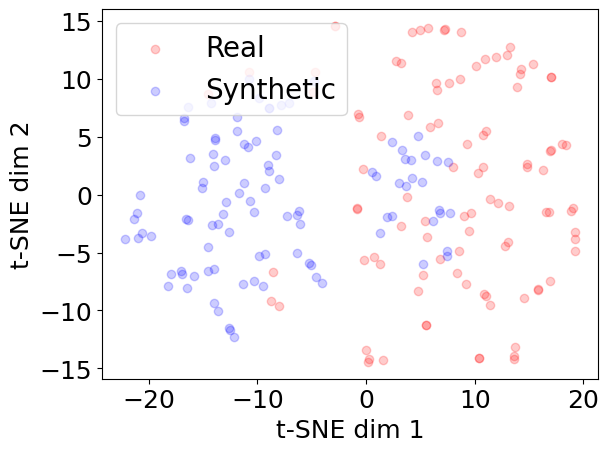

In [7]:
results = trainer.evaluate()
metadata = results["metadata"]
metrics = results["metrics"]